In this notebook I will build and test models using the ESPN headlines data that I webscraped. I will be using both the Multinomial Naive Bayes and Random Forest algorithm from sklearn.

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score, recall_score, precision_score
%matplotlib inline


In [3]:
df = pd.read_csv('data/espn_three_classes.csv') #import the data 

In [4]:
#check for null values
df.isna().sum()

headlines      2
posted_time    0
tokens         0
labels         0
word_length    0
dtype: int64

In [5]:
df.dropna(inplace=True) #drop all null rows

In [6]:
df.nunique()

headlines      36081
posted_time     1880
tokens         36063
labels             3
word_length       20
dtype: int64

In [7]:
df.drop_duplicates(inplace=True) #drop duplicates

In [8]:
df['labels'].value_counts() #checking class balance prior to modeling

0    25189
1     6069
2     5280
Name: labels, dtype: int64

As a reminder here are the descriptions of the topics:

0. Mixed Bag of Topics - major keywords are 'LeBron', 'Warriors', and 'Lakers' and 'Source'
1. Game Scores/Outcomes 
2. NBA Draft and Daily Fantasy Basketball Updates

Although we have a class imbalance, we will build and test baseline models to evaluate performance before deciding if we need to undersample or oversample.

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

In [10]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [11]:
X = df['headlines'] #split headlines 
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [12]:
vectorizer = TfidfVectorizer(stop_words=stopwords)

X_train_sparse = vectorizer.fit_transform(X_train) #fit transform on training data
X_test_sparse = vectorizer.transform(X_test) #transform on testing data

## Multinomial Naive Bayes

In [13]:
mnb_vanilla = MultinomialNB() #instantiate model
mnb_vanilla.fit(X_train_sparse, y_train) #train model

#perform cross validation to ensure we have a robust model
mnb_vanilla_cv = cross_val_score(mnb_vanilla, X_train_sparse, y_train, cv=5, scoring='accuracy', n_jobs=-1)


In [14]:
def summary_scores(model, train_set_x, test_set_x, train_set_y, test_set_y, cross_val_var):
    
    """This is a simple function that will compute the accuracy score for model based on training and 
    testing data.  The user inputs are as follows:
    
    model: instantiated and trained model object.
    train_set_x: training data
    test_set_x: testing data
    train_set_y: target values for training data
    test_set_y: target values for testing data
    cross_Val_var: array-like. Collection of cross-validated scoring metric.
    """
    print(f'Training Accuracy: {model.score(train_set_x, train_set_y)}')
    print(f'Cross Validation Accuracy: {np.mean(cross_val_var)}')
    print(f'Testing Accuracy: {model.score(test_set_x, test_set_y)}')
    print(f'F1 Score: {f1_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Recall: {recall_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Precision: {precision_score(test_set_y, model.predict(test_set_x), average="weighted")}')

In [15]:
summary_scores(mnb_vanilla, X_train_sparse, X_test_sparse, y_train, y_test, mnb_vanilla_cv)

Training Accuracy: 0.9234438536127619
Cross Validation Accuracy: 0.9008835715219231
Testing Accuracy: 0.9088669950738916
F1 Score: 0.9059673155940781
Recall: 0.9088669950738916
Precision: 0.9102216564216669


In [16]:
print(classification_report(y_test, mnb_vanilla.predict(X_test_sparse)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7557
           1       0.89      0.86      0.87      1821
           2       0.94      0.69      0.80      1584

    accuracy                           0.91     10962
   macro avg       0.91      0.84      0.87     10962
weighted avg       0.91      0.91      0.91     10962



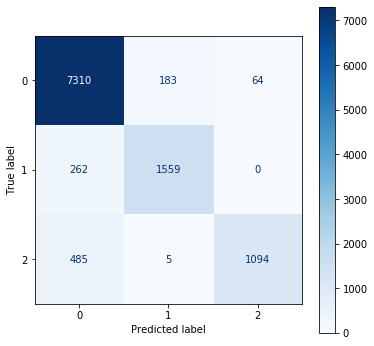

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(mnb_vanilla, X_test_sparse, y_test, cmap='Blues', ax=ax)
plt.savefig('MultinomialNB_vanilla_conf_matrix.png')

The Multinomial Naive Bayes model does incredibly well for a vanilla model.  The worst predicted class is group 2. Given that group zero is a mixed bag of topics, there may be a large enough number of headlines in group zero that are closely related to the NBA draft or NBA fantasy updates to cause those misclassifications. 

We will perform a grid search to see if we can improve the model performance.

In [18]:
mnb_vanilla_param = {'alpha':[0, 0.01, 1, 2, 10],
                     'fit_prior':[True, False]}

gs_mnb = GridSearchCV(mnb_vanilla, param_grid=mnb_vanilla_param, cv=5, n_jobs=-1)
gs_mnb.fit(X_train_sparse, y_train)
gs_mnb.best_params_

{'alpha': 10, 'fit_prior': False}

In [19]:
gs_mnb_vanilla_cv_mean = cross_val_score(gs_mnb, X_train_sparse, y_train,
                                                 cv=5, scoring='accuracy', n_jobs=-1)

In [20]:
summary_scores(gs_mnb, X_train_sparse, X_test_sparse, y_train, y_test, gs_mnb_vanilla_cv_mean)

Training Accuracy: 0.9162105098529871
Cross Validation Accuracy: 0.9060056847320082
Testing Accuracy: 0.9116037219485496
F1 Score: 0.911725412964057
Recall: 0.9116037219485496
Precision: 0.9120937244076862


The grid search optimization does improve the cross validation accuracy slightly, but there is a slight dip in testing accuracy.

Considering that we haven't used PCA to reduce the components (and still have ~12,000 unique tokens) it is encouraging to know that the model is not overfitting the data. Obviously, we would need to test the model on a new set of headlines that weren't part of the clustering we did previously to ensure the the model is fully generalizable.

## Random Forests

In [21]:
rf_vanilla = RandomForestClassifier()
rf_vanilla.fit(X_train_sparse, y_train)
rf_vanilla_cv = cross_val_score(rf_vanilla, X_train_sparse, y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [22]:
summary_scores(rf_vanilla, X_train_sparse, X_test_sparse, y_train, y_test, rf_vanilla_cv)

Training Accuracy: 1.0
Cross Validation Accuracy: 0.9759539351751009
Testing Accuracy: 0.9767378215654078
F1 Score: 0.9770638103387119
Recall: 0.9767378215654078
Precision: 0.9781790460544196


In [23]:
print(classification_report(y_test, rf_vanilla.predict(X_test_sparse)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7557
           1       0.90      0.98      0.94      1821
           2       0.99      0.99      0.99      1584

    accuracy                           0.98     10962
   macro avg       0.96      0.98      0.97     10962
weighted avg       0.98      0.98      0.98     10962



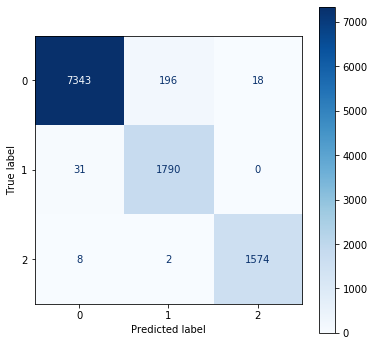

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(rf_vanilla, X_test_sparse, y_test, cmap='Blues', ax=ax)
plt.savefig('random_forest_vanilla_conf_matrix.png')

In [25]:
#store tree depths in a list
vanilla_tree_depths = [estimator.get_depth() for estimator in rf_vanilla.estimators_] 

In [26]:
vanilla_tree_depths #check depths of each tree

[332,
 179,
 294,
 342,
 182,
 207,
 285,
 208,
 217,
 305,
 181,
 196,
 286,
 247,
 242,
 366,
 197,
 221,
 219,
 253,
 302,
 213,
 243,
 249,
 171,
 305,
 266,
 403,
 174,
 307,
 216,
 181,
 230,
 379,
 427,
 425,
 198,
 212,
 269,
 276,
 268,
 333,
 253,
 339,
 333,
 236,
 198,
 229,
 171,
 234,
 263,
 200,
 228,
 229,
 493,
 259,
 307,
 301,
 319,
 443,
 258,
 237,
 245,
 227,
 168,
 207,
 258,
 256,
 194,
 192,
 226,
 305,
 193,
 267,
 219,
 424,
 286,
 196,
 207,
 206,
 224,
 262,
 324,
 254,
 249,
 278,
 271,
 213,
 235,
 248,
 247,
 232,
 310,
 264,
 292,
 215,
 230,
 253,
 320,
 203]

The vanilla model for the random forest is even more accurate than the naive bayes model! With three general topics, we can pretty easily classify these headlines which means we could certainly (after more testing) use this classification model as the first half to a recommendation engine.

## Using Relabeled Data from Group Zero

Since the two vanilla models we built that had 3 classes performed so well, it is time to see if the model peformance holds up when we introduce more specific classes. Again I'll just be using the multinomial bayes and random forest algorithms.

In [27]:
espn_df = pd.read_csv('data/espn_three_classes.csv')

In [28]:
grp_zero_recluster = pd.read_csv('data/espn_grp_zero_recluster.csv')

In [29]:
grp_zero_recluster.head()

,headlines,posted_time,tokens,labels,secondary_labels,kmeans_3_labels
0,Wade matches King for 42nd on scoring list in win,2016-02-01,"['wade', 'match', 'king', '42nd', 'scoring', '...",0,0,0
1,"Chick Hearn's widow, Marge Hearn, dies at 98",2016-01-31,"['chick', 'hearns', 'widow', 'marge', 'hearn',...",0,0,0
2,Wittman to miss 2 games after brother's death,2016-01-31,"['wittman', 'miss', '2', 'game', 'brother', 'd...",0,0,0
3,LeBron atones for wardrobe mismatch vs. Spurs,2016-01-31,"['lebron', 'atones', 'wardrobe', 'mismatch', '...",0,0,1
4,Source: Rockets petition to rescind Howard's t...,2016-01-31,"['source', 'rocket', 'petition', 'rescind', 'h...",0,0,0


In [30]:
grp_zero_recluster['secondary_labels'].value_counts()

0    23413
1     1808
Name: secondary_labels, dtype: int64

In [31]:
grp_zero_recluster.rename(columns={'secondary_labels':'four_labels','kmeans_3_labels':'five_labels'}, 
                          inplace=True) #rename columns

In [32]:
grp_zero_recluster['four_labels'] = grp_zero_recluster['four_labels'] + 3 #change value of labels for subclusters
grp_zero_recluster['five_labels'] = grp_zero_recluster['five_labels'] + 3

In [33]:
grp_zero_recluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25221 entries, 0 to 25220
Data columns (total 6 columns):
headlines      25219 non-null object
posted_time    25221 non-null object
tokens         25221 non-null object
labels         25221 non-null int64
four_labels    25221 non-null int64
five_labels    25221 non-null int64
dtypes: int64(3), object(3)
memory usage: 1.2+ MB


In [38]:
espn_df_grp_one = espn_df.loc[espn_df['labels'] == 1] #grab all original group one headlines
espn_df_grp_two = espn_df.loc[espn_df['labels'] == 2] #grab all original group two headlines


espn_df_grp_one['four_labels'] = 1
espn_df_grp_one['five_labels'] = 1

espn_df_grp_two['four_labels'] = 2
espn_df_grp_two['five_labels'] = 2

/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [39]:
espn_df_grp_one.drop(columns=['word_length'], inplace=True)
espn_df_grp_two.drop(columns=['word_length'], inplace=True)

/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
#create new variable for relabeled dataframe
df_relabel = pd.concat([grp_zero_recluster, espn_df_grp_one, espn_df_grp_two], ignore_index=True)

In [41]:
df_relabel.head()

,headlines,posted_time,tokens,labels,four_labels,five_labels
0,Wade matches King for 42nd on scoring list in win,2016-02-01,"['wade', 'match', 'king', '42nd', 'scoring', '...",0,3,3
1,"Chick Hearn's widow, Marge Hearn, dies at 98",2016-01-31,"['chick', 'hearns', 'widow', 'marge', 'hearn',...",0,3,3
2,Wittman to miss 2 games after brother's death,2016-01-31,"['wittman', 'miss', '2', 'game', 'brother', 'd...",0,3,3
3,LeBron atones for wardrobe mismatch vs. Spurs,2016-01-31,"['lebron', 'atones', 'wardrobe', 'mismatch', '...",0,3,4
4,Source: Rockets petition to rescind Howard's t...,2016-01-31,"['source', 'rocket', 'petition', 'rescind', 'h...",0,3,3


In [ ]:
df_relabel.to_csv('espn_df_recluster.csv', index=False)

In [42]:
df_relabel.isna().sum()

headlines      2
posted_time    0
tokens         0
labels         0
four_labels    0
five_labels    0
dtype: int64

In [43]:
df_relabel.dropna(inplace=True) #drop nulls and duplicates
df_relabel.drop_duplicates(inplace=True)

In [44]:
df_relabel['four_labels'].value_counts()

3    23382
1     6069
2     5280
4     1807
Name: four_labels, dtype: int64

Because we relabeled the classes the topics are as follows (for 4 classes):

1. Game Scores and Outcomes
2. NBA Draft and Daily Fantasy Basketball Updates
3. Mixed Bag of Topics
4. Contracts and Player Signings

In [45]:
df_relabel['five_labels'].value_counts()

3    22547
1     6069
2     5280
5     1382
4     1260
Name: five_labels, dtype: int64

For 5 classes the topics are as follows:

1. Game Scores and Outcomes
2. NBA Draft and Daily Fantasy Basketball Updates
3. Mixed Bag of Topics
4. Contracts and Player Signings
5. Golden State Warriors

In [46]:
vectorizer_four = TfidfVectorizer() #instantiate vectorizers
vectorizer_five = TfidfVectorizer()
X_relab = df_relabel['headlines']
y_four = df_relabel['four_labels'] #create target variable for 4 classes
y_five = df_relabel['five_labels'] #create target variable for 5 classes

In [47]:
#test train split
X_train_four, X_test_four, y_train_four, y_test_four = train_test_split(X_relab, y_four, 
                                                                        test_size=0.3, stratify=y_four,
                                                                        random_state=123)

In [48]:
X_train_five, X_test_five, y_train_five, y_test_five = train_test_split(X_relab, y_five, test_size=0.3,
                                                                       stratify=y_five, random_state=123)

In [49]:
X_train_four_sparse = vectorizer_four.fit_transform(X_train_four) 
X_test_four_sparse = vectorizer_four.transform(X_test_four)
X_train_five_sparse = vectorizer_five.fit_transform(X_train_five)
X_test_five_sparse = vectorizer_five.transform(X_test_five)

In [50]:
mnb_four = MultinomialNB()
mnb_four.fit(X_train_four_sparse, y_train_four)
mnb_four_cv_mean = cross_val_score(mnb_four, X_train_four_sparse, 
                                   y_train_four, cv=5, n_jobs=-1, scoring='accuracy')

In [51]:
summary_scores(mnb_four, X_train_four_sparse, X_test_four_sparse, y_train_four, y_test_four, mnb_four_cv_mean)

Training Accuracy: 0.8897012824522991
Cross Validation Accuracy: 0.8613152840417083
Testing Accuracy: 0.8641671227878125
F1 Score: 0.8523048721302369
Recall: 0.8641671227878125
Precision: 0.8733885821508949


In [52]:
mnb_five = MultinomialNB()
mnb_five.fit(X_train_five_sparse, y_train_five)
mnb_five_cv = cross_val_score(mnb_five, X_train_five_sparse, y_train_five, cv=5, n_jobs=-1, scoring='accuracy')

In [53]:
summary_scores(mnb_five, X_train_five_sparse, X_test_five_sparse, y_train_five, y_test_five, mnb_five_cv)

Training Accuracy: 0.8567015952455427
Cross Validation Accuracy: 0.8330856752854785
Testing Accuracy: 0.8345192483123518
F1 Score: 0.8005556755562844
Recall: 0.8345192483123518
Precision: 0.8152184714765602


/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
rf_four = RandomForestClassifier()
rf_four.fit(X_train_four_sparse, y_train_four)
rf_four_cv = cross_val_score(rf_four, X_train_four_sparse, y_train_four, cv=5, n_jobs=-1, scoring='accuracy')

In [55]:
summary_scores(rf_four, X_train_four_sparse, X_test_four_sparse, y_train_four, y_test_four, rf_four_cv)

Training Accuracy: 1.0
Cross Validation Accuracy: 0.9750937277641608
Testing Accuracy: 0.972997628170042
F1 Score: 0.9733017635379674
Recall: 0.972997628170042
Precision: 0.9743580857306723


In [56]:
rf_five = RandomForestClassifier()
rf_five.fit(X_train_five_sparse, y_train_five)
rf_five_cv = cross_val_score(rf_five, X_train_five_sparse, y_train_five, cv=5, n_jobs=-1, scoring='accuracy')

In [57]:
summary_scores(rf_five, X_train_five_sparse, X_test_five_sparse, y_train_five, y_test_five, rf_five_cv)

Training Accuracy: 1.0
Cross Validation Accuracy: 0.9750547646507192
Testing Accuracy: 0.9727239554825762
F1 Score: 0.9730679628166591
Recall: 0.9727239554825762
Precision: 0.974227836821246


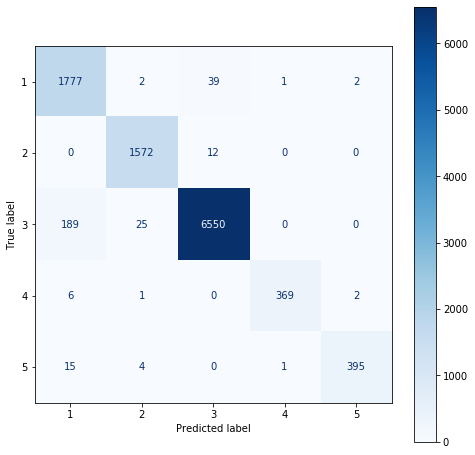

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
plot_confusion_matrix(rf_five, X_test_five_sparse, y_test_five, cmap='Blues', ax=ax)
plt.savefig('random_forest_five_classes_conf_matrix.png')

In [59]:
print(classification_report(y_test_five, rf_five.predict(X_test_five_sparse)))

              precision    recall  f1-score   support

           1       0.89      0.98      0.93      1821
           2       0.98      0.99      0.99      1584
           3       0.99      0.97      0.98      6764
           4       0.99      0.98      0.99       378
           5       0.99      0.95      0.97       415

    accuracy                           0.97     10962
   macro avg       0.97      0.97      0.97     10962
weighted avg       0.97      0.97      0.97     10962



For Multinomial Naive Bayes, the performance suffers as we increase the number of classes. Introducing four classes caused a 4% overall drop in accuracy and 5 classes caused another 3% drop in accuracy. Notably, 83% accuracy with 5 classes is not terrible but if we were to try and further segment the data, the naive bayes model likely would not be our best choice.

The random forest model manages to hold up in terms of performance as we increase the number of classes. The headlines from the mixed bag of topics class(i.e. class 3 when relabeled) and the game scores/outcomes class seem like they may be close to each other if we were to map them in 2D space. We might try to further segment the mixed bag of topics class in order to prevent misclassification given that the random forest model still has high accuracy with a greater number of classes. The random forest model does slightly worse with 5 topics but I argue that the difference is negligible if we can be more specific in our classification and therefore more specific in classifying content for a potential user.

## Conclusion 

The random forest algorithm outperforms the naive Bayes algorithm for both 3 and 5 classes and is the preferred algorithm when putting a model into production.

A top down approach is best for identifying topics. Although we have one cluster that is a mixed bag of topics, we can look for smaller clusters within that larger cluster as necessary if we want to develop a more unique experience for fans.

Rankings/fantasy sports is one of the major clusters found using kmeans. We might look for specific team or players clusters (like the cluster with headlines about the Golden State Warriors) so that we can develop a model that sources news about the players on individual's fantasy team.

With respect to headlines, we would look to gather more headlines from different sources to see if the topics within a corpus remain consistent. If the topics changed that would require separate data analysis and modeling.